# Generic forecast skill

This notebook contains plots showing the skill of commonly assessed variables and indices. Results are shown for CAFE-f6 and for the CanESM5 and EC-Earth3 CMIP6 DCPP submissions. 30-year climatological and verification periods are used for both the CAFE-f6 and CMIP6 data. However, because the historical CMIP6 data end in 2014, these periods differ slightly: 1991-2020 for CAFE-f6; 1985-2014 for CanESM5 and EC-Earth3.

Significant points (as identified by a non-parametric block bootstrapping procedure) are shown by hatching for the maps and filled circles for the line plots.

If you wish to see anything added to these results, please contact Dougie.

In [1]:
import cftime

import xarray as xr
import xskillscore as xs

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from src import plot

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
def _load_skill_metric(
    hindcast, reference, timescale, variable, metric, verif_period=None
):
    """Load a skill metric"""
    SKILL_DIR = "../data/skill/"
    if hindcast == "CAFEf6":
        anom_period = "1991-2020"
    else:
        anom_period = "1985-2014"
    if verif_period is None:
        verif_period = anom_period
    file = (
        f"{SKILL_DIR}/{hindcast}.{reference}.{timescale}.anom_{anom_period}"
        f".{variable}.{metric}_{verif_period}.zarr"
    )
    return xr.open_zarr(file).compute()

In [4]:
def plot_skill_timeseries(
    hindcasts,
    reference,
    timescale,
    variable,
    metrics,
    verif_period=None,
    figsize=(9, 4),
):
    """
    Helper function for plotting some skill scores.
    """
    from itertools import cycle

    fig, ax = plt.subplots(figsize=figsize)

    colors = ["C0", "C1", "C2", "C3", "C5"]
    colorcycler = cycle(colors)
    plot_lines = []
    for hindcast in hindcasts:
        color = next(colorcycler)
        lines = ["-", "--", "-.", ":"]
        linecycler = cycle(lines)
        metric_lines = []
        for metric in metrics:
            try:
                skill = _load_skill_metric(
                    hindcast, reference, timescale, variable, metric, verif_period
                )
                line = next(linecycler)
                (p,) = skill[variable].plot(
                    ax=ax,
                    linestyle=line,
                    color=color,
                )
                skill[variable].where(skill[f"{variable}_signif"]).plot(
                    ax=ax, linestyle="none", marker="o", color=color
                )
                metric_lines.append(p)
            except:
                pass
        plot_lines.append(metric_lines)

    legend1 = ax.legend([l[0] for l in plot_lines], hindcasts, loc=1)
    if len(metrics) > 1:
        ax.legend(plot_lines[0], metrics, loc=4)
        ax.add_artist(legend1)
        ax.set_ylabel("Skill")
    else:
        ax.set_ylabel(metrics[0])

    ax.set_xlabel(f"Final lead month of {timescale} average")
    ax.set_ylim(top=1)
    ax.grid()

    return skill

In [5]:
def plot_skill_maps(
    hindcasts,
    reference,
    variable,
    metric,
    verif_period=None,
):
    """
    Helper function for plotting some skill maps. Edit this function to change which
    lead times are plotted
    """

    fields = []
    headings = []
    for hindcast in hindcasts:
        annual = _load_skill_metric(
            hindcast, reference, "annual", variable, metric, verif_period
        )
        quadrennial = _load_skill_metric(
            hindcast, reference, "4-year", variable, metric, verif_period
        )

        # Change this to change what leads are plotted
        to_plot = {
            "year 1": annual.sel(lead=23),
            "years 1-4": quadrennial.sel(lead=59),
            "years 5-8": quadrennial.sel(lead=107),
        }
        fields.append(list(to_plot.values()))
        headings.append(
            [f"{hindcast} | {metric} | {timescale}" for timescale in to_plot.keys()]
        )

    if len(hindcasts) >= 3:
        figsize = (15, 9.1)
    elif len(hindcasts) == 2:
        figsize = (15, 6.1)
    else:
        figsize = (15, 3.2)
    return plot.skill_maps(
        fields, variable=variable, vrange=(-1, 1), headings=headings, figsize=figsize
    )

## Sea surface temperature relative to HadISST
### Anomaly correlation coefficient

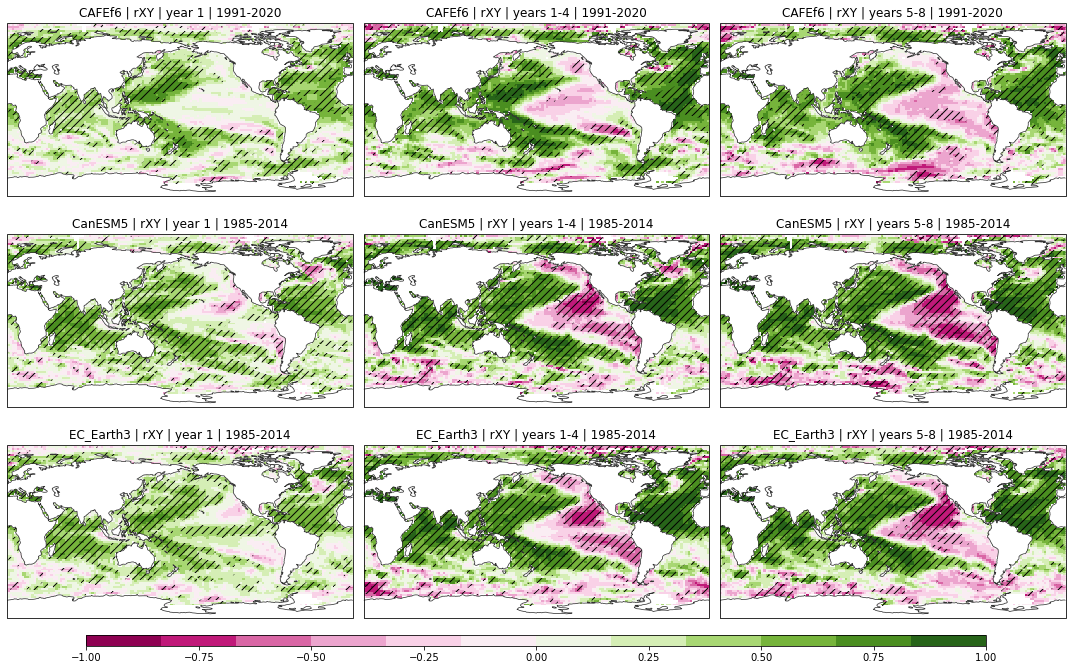

In [6]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "rXY")

#### What are those big patches of negative correlation in the Pacific the 4-year averages?
These aren't apparent in the CanESM5 verification paper. Are they an artifact of differing "trends" over the short verifcation period? Let's look at the skill of CanESM5 and EC_Earth3 over a longer (1971-2017) period of time

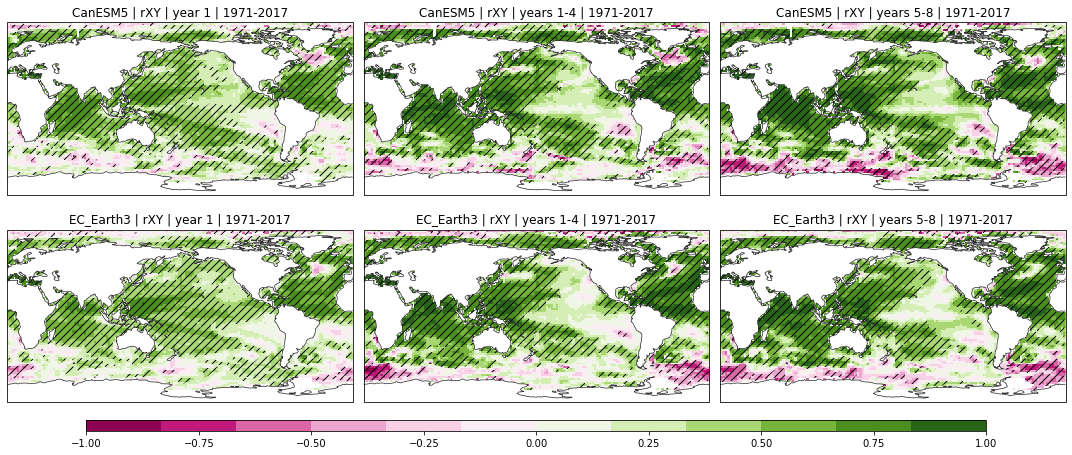

In [7]:
_ = plot_skill_maps(
    ["CanESM5", "EC_Earth3"], "HadISST", "sst", "rXY", verif_period="1971-2017"
)

This looks more like the results in the CanESM5 verification paper. So we need to be pretty careful interpretting the anomaly correlation coefficient over our short verification period. Let's demonstrate this by looking at the hindcast and observed timeseried at a location in the Pacific:

In [8]:
location = dict(lon=225, lat=10)
full_period = slice("1971", "2017")
verif_period = slice("1985", "2014")

hcst = xr.open_zarr("../data/processed/CanESM5.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
hcst = (
    hcst["sst"]
    .mean("member")
    .sel(lead=59)
    .swap_dims({"init": "time"})
    .sel(time=full_period)
)

obsv = xr.open_zarr("../data/processed/HadISST.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
obsv = obsv["sst"].sel(time=hcst.time)

acc_full_period = xs.pearson_r(hcst, obsv, dim="time").values.item()

acc_verif_period = xs.pearson_r(
    hcst.sel(time=verif_period), obsv.sel(time=verif_period), dim="time"
).values.item()

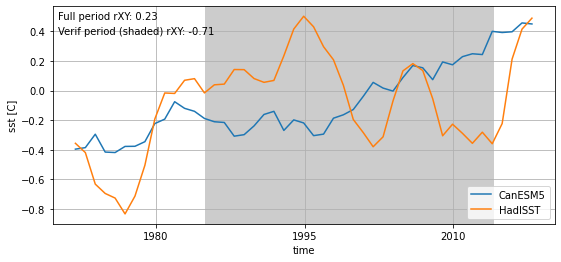

In [9]:
fig, ax = plt.subplots(figsize=(9, 4))

hcst.plot(label="CanESM5")
obsv.plot(label="HadISST")
ylim = plt.gca().get_ylim()
plt.fill_between(
    [cftime.datetime(1985, 1, 1), cftime.datetime(2014, 1, 1)],
    [ylim[0], ylim[0]],
    [ylim[1], ylim[1]],
    color=[0.8, 0.8, 0.8],
)
plt.gca().set_ylim(ylim)
plt.title("")
plt.legend(loc="lower right")
plt.grid()

plt.text(
    0.01,
    0.98,
    f"Full period rXY: {acc_full_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)
_ = plt.text(
    0.01,
    0.91,
    f"Verif period (shaded) rXY: {acc_verif_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)

### Initialised component of the anomaly correlation coefficient
(see https://doi.org/10.1029/2019GL086361)

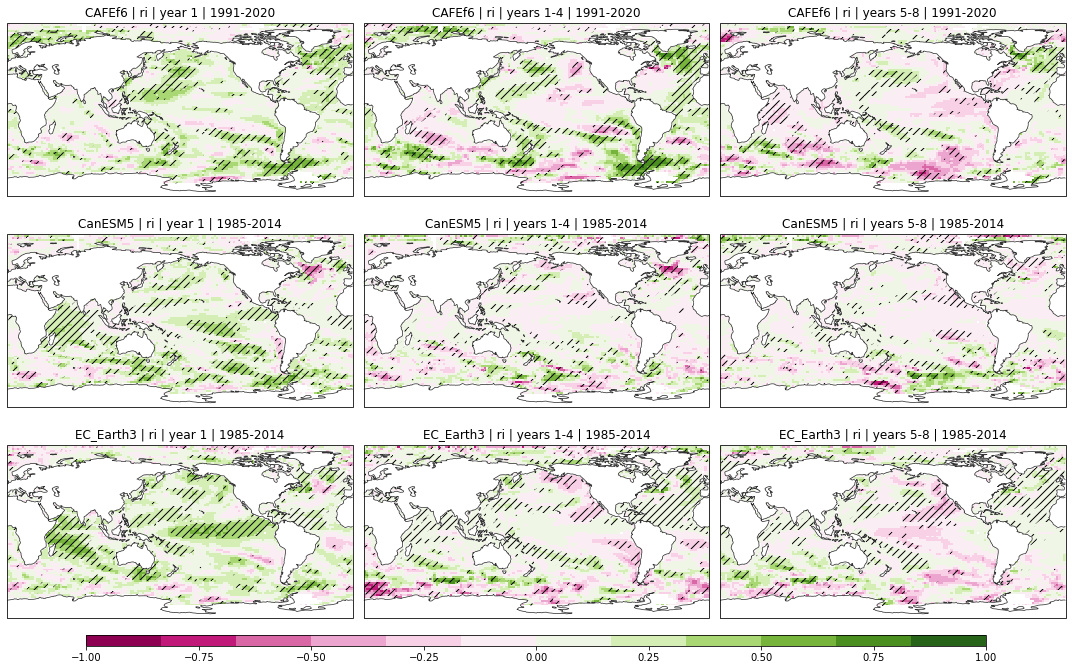

In [10]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "ri")

### Mean squared skill score relative to historical simulations

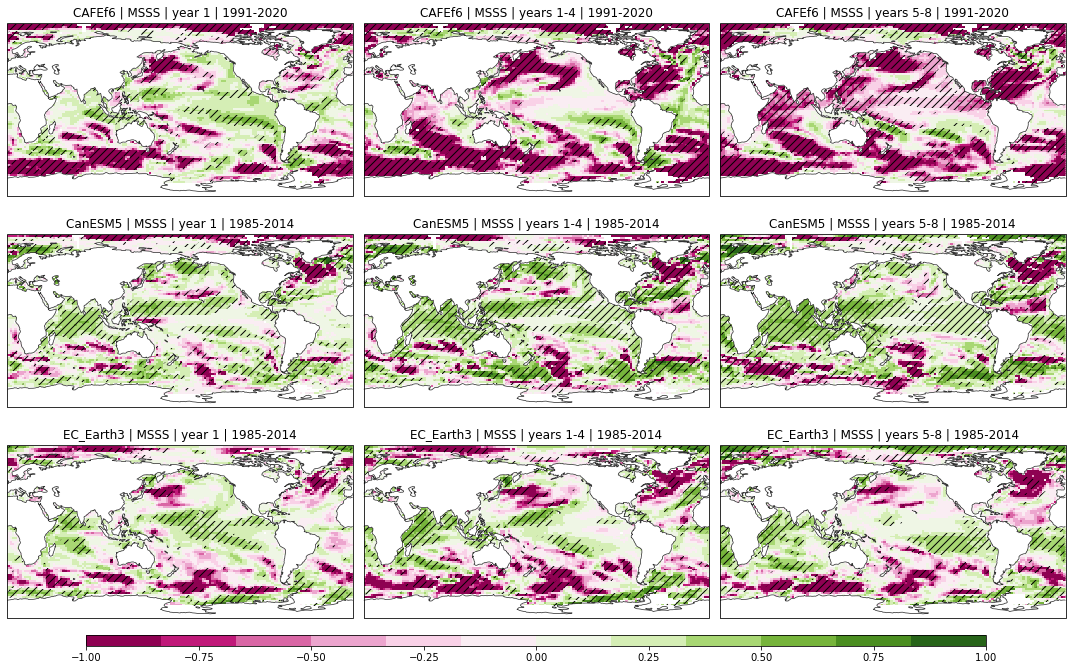

In [11]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "MSSS")

### Rank probability skill score relative to historical simulations

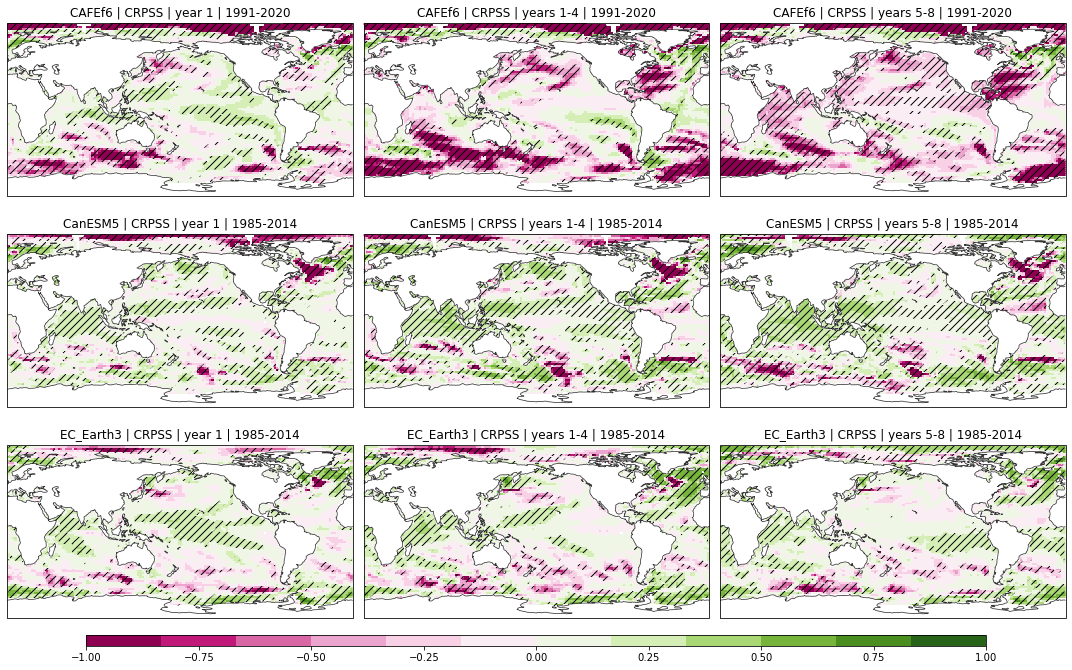

In [12]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "sst", "CRPSS")

## Near-surface (2m) temperature relative to JRA55
### Anomaly correlation coefficient

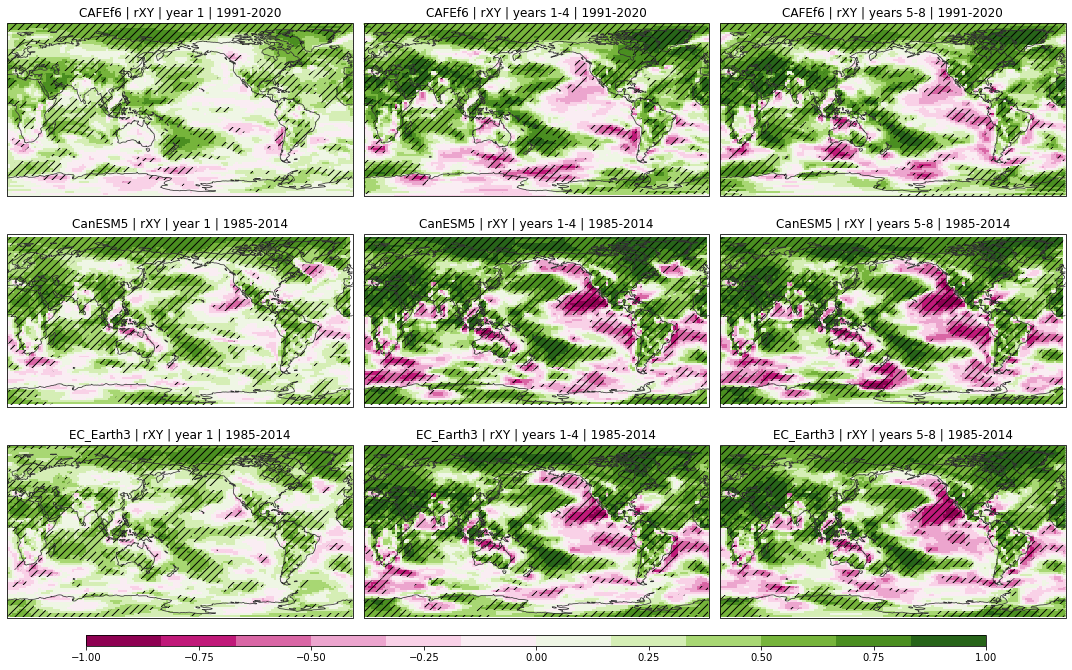

In [13]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "rXY")

### Initialised component of the anomaly correlation coefficient
(see https://doi.org/10.1029/2019GL086361)

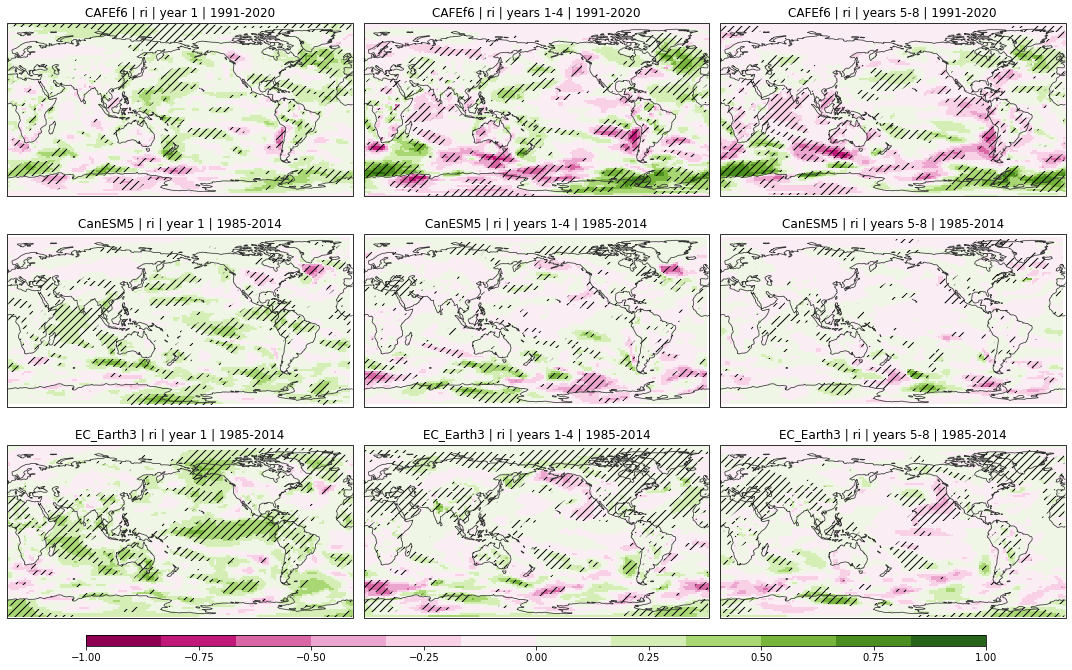

In [14]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "ri")

### Mean squared skill score relative to historical simulations

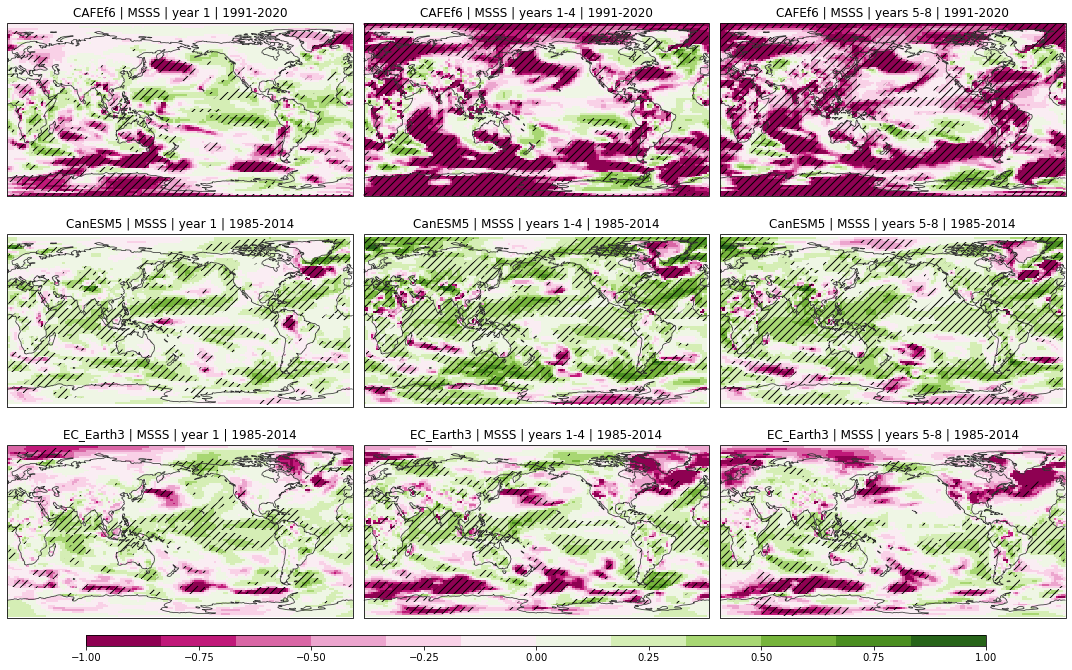

In [15]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "MSSS")

### Rank probability skill score relative to historical simulations

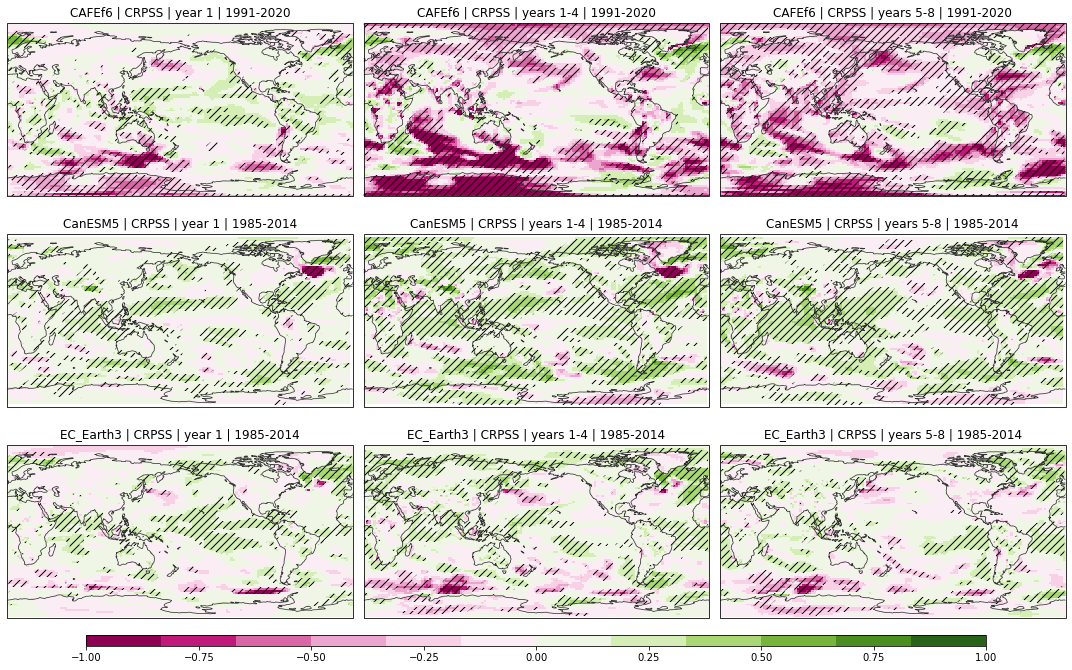

In [16]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "JRA55", "t_ref", "CRPSS")

## Precipitation relative to GPCP
### Anomaly correlation coefficient

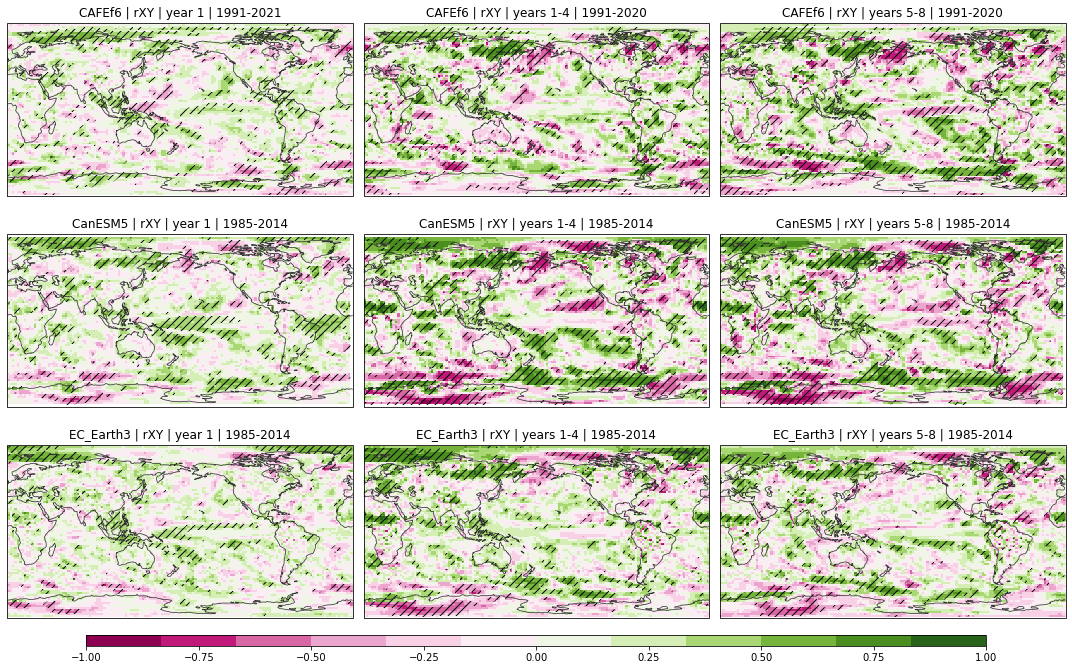

In [17]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "rXY")

### Initialised component of the anomaly correlation coefficient
(see https://doi.org/10.1029/2019GL086361)

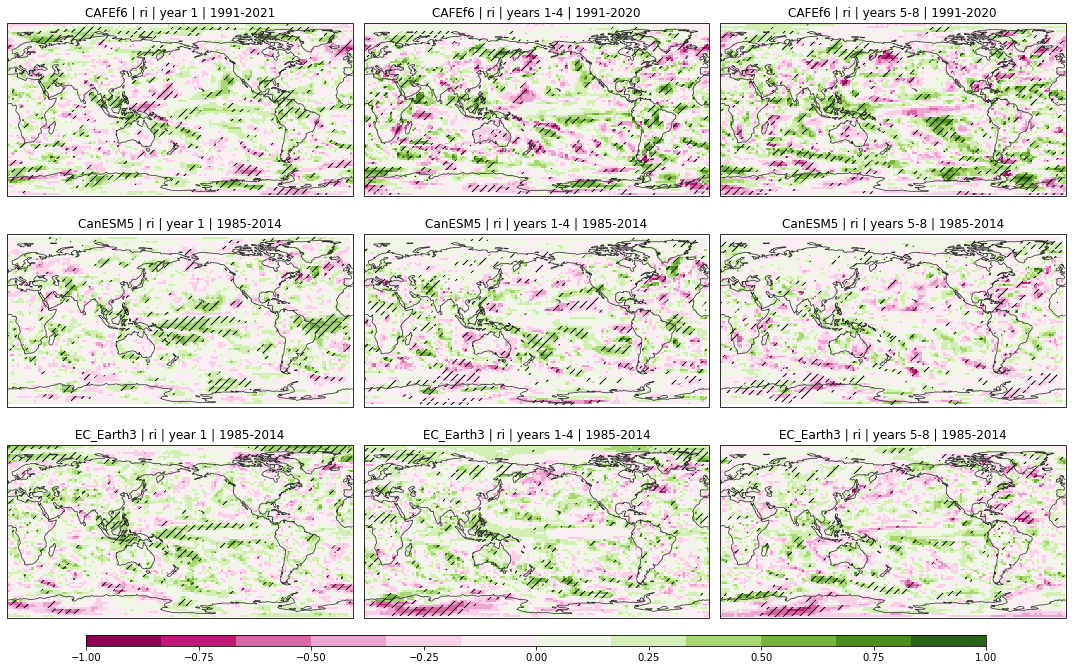

In [18]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "ri")

### Mean squared skill score relative to historical simulations

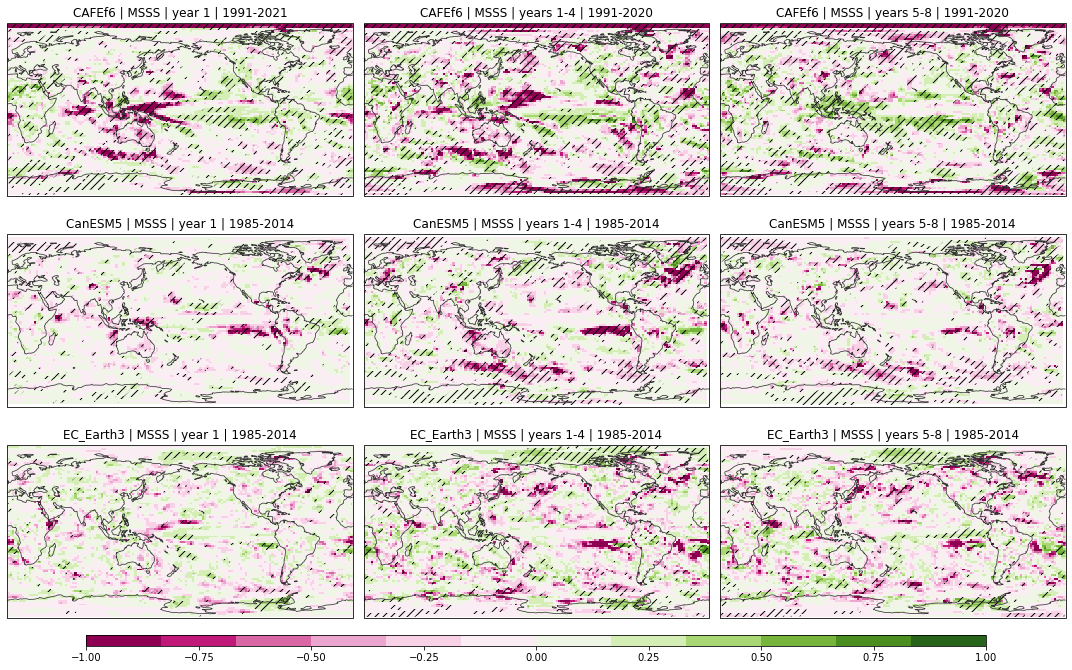

In [19]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "MSSS")

### Rank probability skill score relative to historical simulations

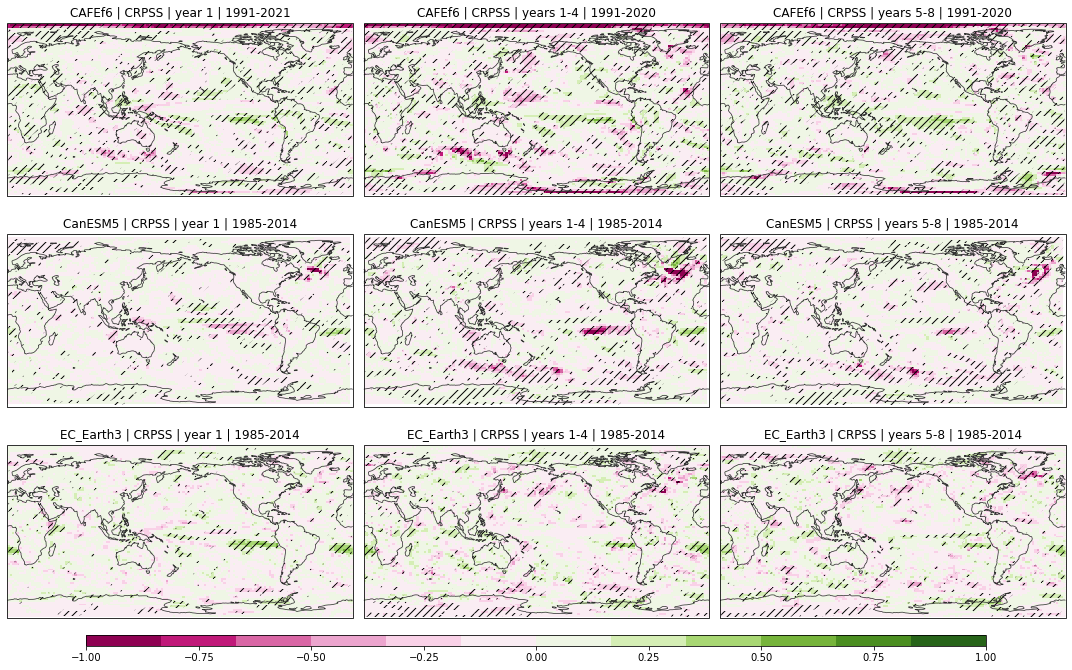

In [20]:
_ = plot_skill_maps(["CAFEf6", "CanESM5", "EC_Earth3"], "GPCP", "precip", "CRPSS")

## Upper ocean heat content (upper 300m) relative to EN.4.2.2
### Anomaly correlation coefficient

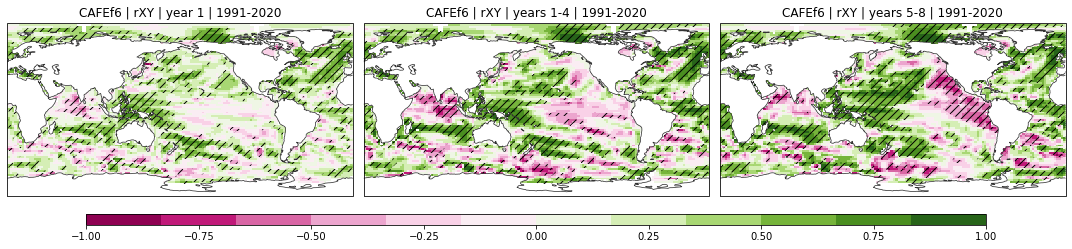

In [21]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "rXY")

### Initialised component of the anomaly correlation coefficient
(see https://doi.org/10.1029/2019GL086361)

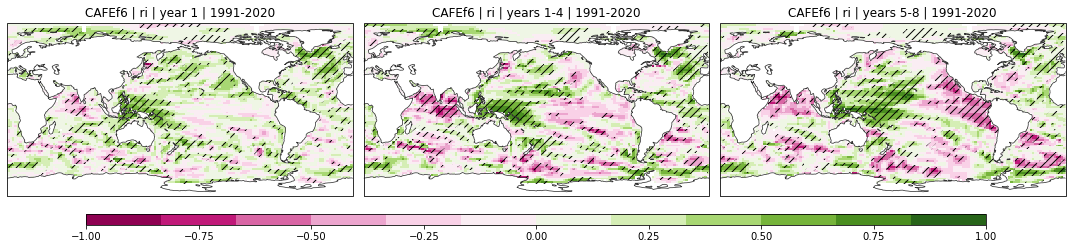

In [22]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "ri")

### Mean squared skill score relative to historical simulations

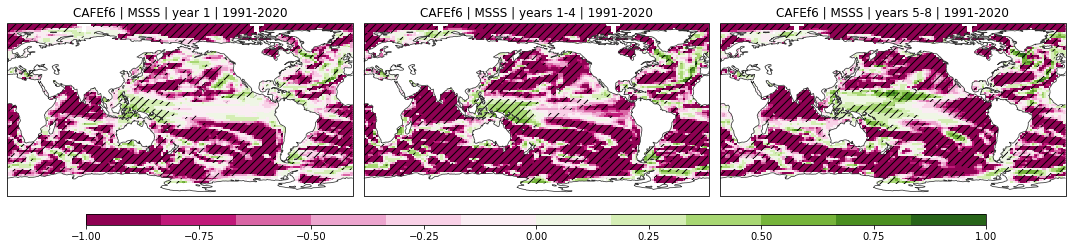

In [23]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "MSSS")

### Rank probability skill score relative to historical simulations

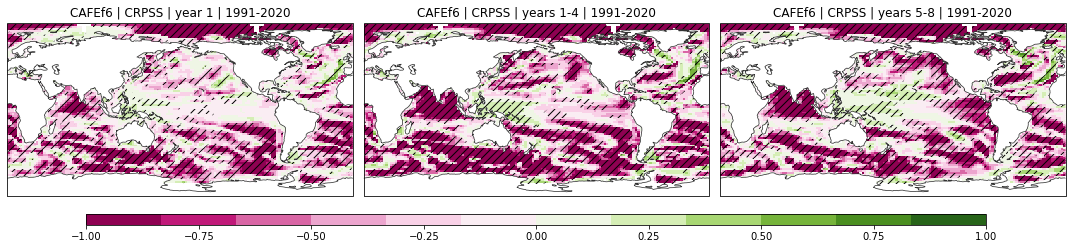

In [24]:
_ = plot_skill_maps(["CAFEf6"], "EN422", "ohc300", "CRPSS")

## El-Nino Southern Oscillation (via NINO 3.4) relative to HadISST

### Anomaly correlation coefficient

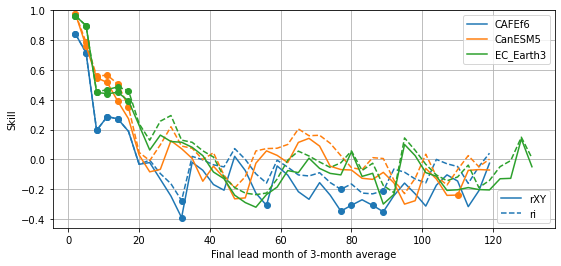

In [6]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "nino34", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

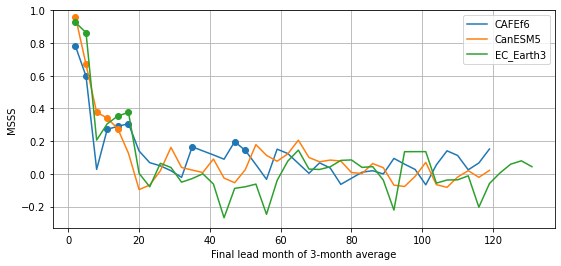

In [7]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "nino34", ["MSSS"]
)

### Rank probability skill score relative to historical simulations

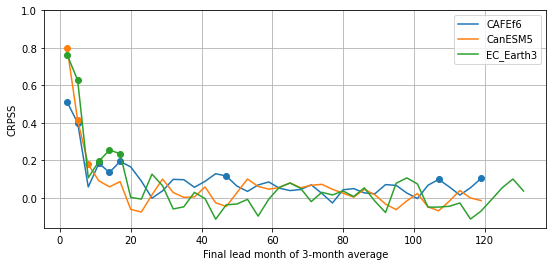

In [8]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "nino34", ["CRPSS"]
)

## Indian Ocean Dipole (via DMI) relative to HadISST

### Anomaly correlation coefficient

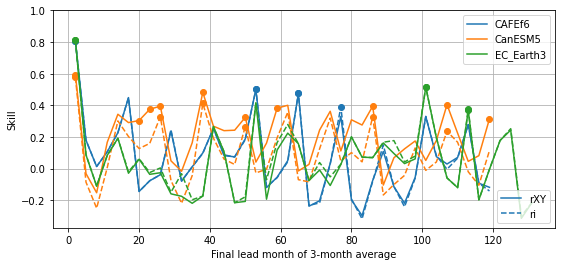

In [9]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "dmi", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

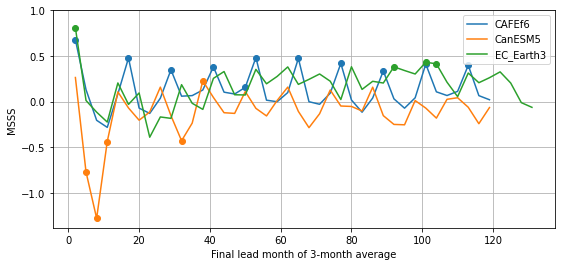

In [10]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "dmi", ["MSSS"]
)

### Rank probability skill score relative to historical simulations

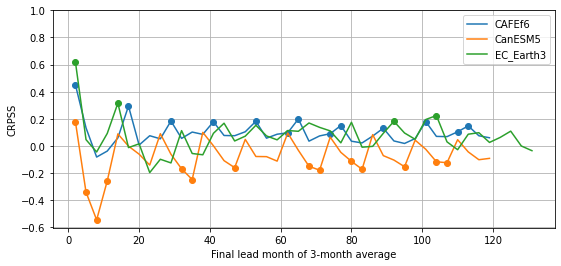

In [11]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "3-month", "dmi", ["CRPSS"]
)

## Southern Annual Mode (via Gong and Wang Index) relative to JRA55

### Anomaly correlation coefficient

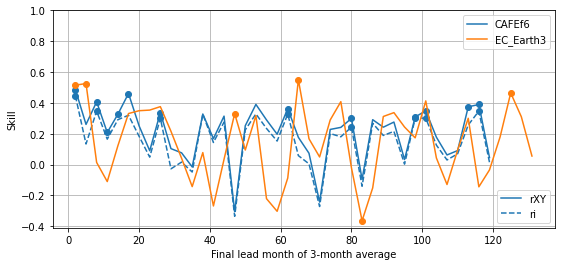

In [12]:
_ = plot_skill_timeseries(
    ["CAFEf6", "EC_Earth3"], "JRA55", "3-month", "sam", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

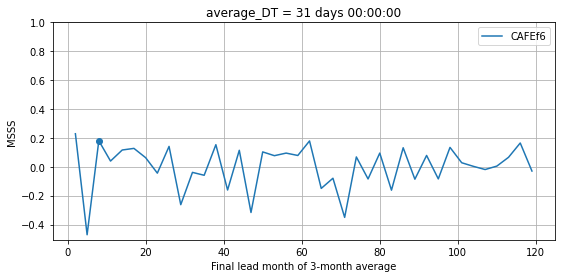

In [13]:
_ = plot_skill_timeseries(["CAFEf6"], "JRA55", "3-month", "sam", ["MSSS"])

### Rank probability skill score relative to historical simulations

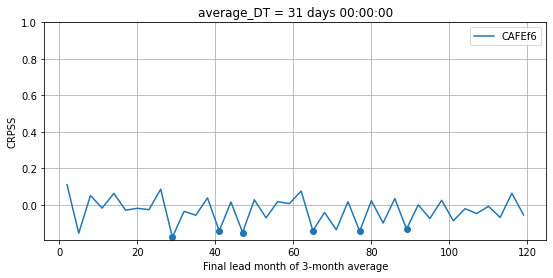

In [14]:
_ = plot_skill_timeseries(["CAFEf6"], "JRA55", "3-month", "sam", ["CRPSS"])

## North Atlantic Oscillation Index (via Jianping and Wang Index) relative to JRA55

### Anomaly correlation coefficient

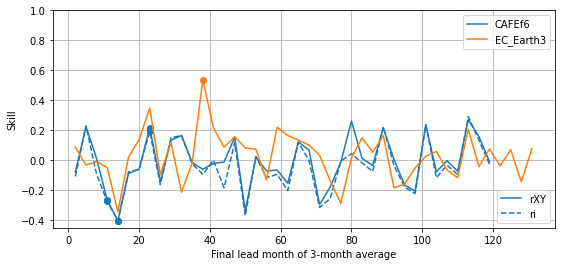

In [15]:
_ = plot_skill_timeseries(
    ["CAFEf6", "EC_Earth3"], "JRA55", "3-month", "nao", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

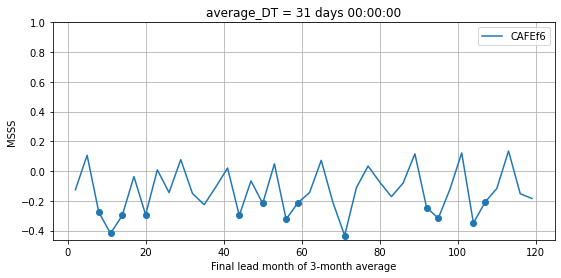

In [16]:
_ = plot_skill_timeseries(["CAFEf6"], "JRA55", "3-month", "nao", ["MSSS"])

### Rank probability skill score relative to historical simulations

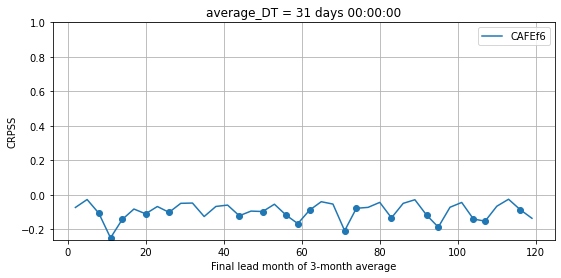

In [17]:
_ = plot_skill_timeseries(["CAFEf6"], "JRA55", "3-month", "nao", ["CRPSS"])

## Atlantic multi-decadal variability relative to HadISST
(see https://doi.org/10.1029/2006GL026894)

### Anomaly correlation coefficient

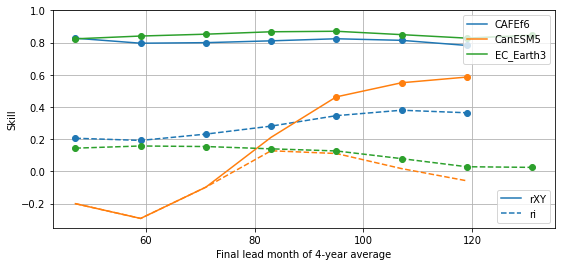

In [18]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "amv", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

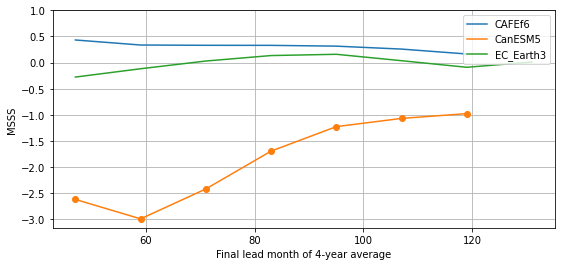

In [19]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "amv", ["MSSS"]
)

### Rank probability skill score relative to historical simulations

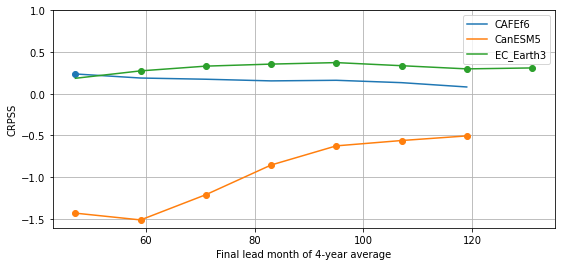

In [20]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "amv", ["CRPSS"]
)

## Inter-decadal Pacific oscillation relative to HadISST
(see https://doi.org/10.1007/s00382-015-2525-1)

### Anomaly correlation coefficient

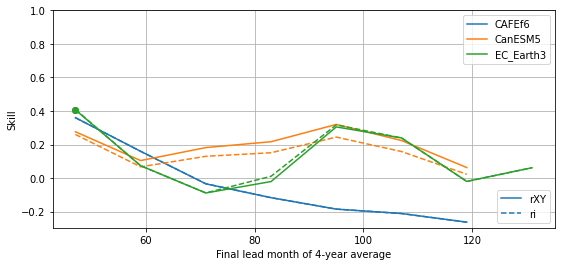

In [21]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "ipo", ["rXY", "ri"]
)

### Mean squared skill score relative to historical simulations

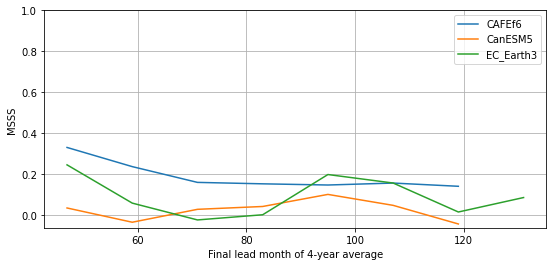

In [22]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "ipo", ["MSSS"]
)

### Rank probability skill score relative to historical simulations

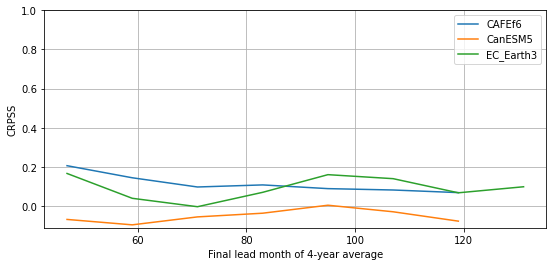

In [23]:
_ = plot_skill_timeseries(
    ["CAFEf6", "CanESM5", "EC_Earth3"], "HadISST", "4-year", "ipo", ["CRPSS"]
)